<a href="https://colab.research.google.com/github/xusky69/dissipative-dynamics/blob/main/qutip_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qutip

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from qutip import *

sns.set_theme()

# QuTIP dissipative quantum dynamics


In [3]:
def quantumDissipativeCircuit(H_0, V, circuit, rho, observables, plot = True):
    '''
    Recibe:
        H_0: hamiltoniano del sistema + baño
        V: hamiltoniano de acople baño-sistema, lista de 1 elemento
        circuit: lista de tuplas (Gate, Time) que definen las compuertas y su respectivo tiempo de aplicación
        rho: matriz densidad inicial del sistema
        observables: lista de tuplas (observables, etiquetas), observables a medir y sus respectivas etiquetas
        plot: graficar o no
    Retorna:
        rho: matriz densidad final del sistema
        t : lista de tiempos
        results: valor esperado de los observables para t
    '''

    applyGate = lambda rho, gate : gate*rho*gate.dag()
    circuit.sort(key = lambda arr : arr[1])
    obs = list(map(lambda arr : arr[0], observables))
    labels = list(map(lambda arr : arr[1], observables))
    prev_time = 0
    t_list = []
    results = []
    final_results = []

    for gate,time in circuit:
        t = np.linspace(prev_time, time, 100)
        t_list.append(t)
        states = mesolve(H_0, rho, t, V, []).states
        results.append(mesolve(H_0, rho, t, V, obs).expect)
        rho = applyGate(states[-1], gate)
        prev_time = time

    if plot:
        fig = plt.figure(dpi = 80)
        for i in range(len(obs)):
            final_result = np.concatenate(list(map(lambda arr : arr[i], results)))
            final_results.append(final_result)
            plt.plot(np.concatenate(t_list), final_result)
        plt.legend(labels)
        plt.title('Dissipative quantum circuit' if len(V) != 0 else 'Ideal quantum circuit')
        plt.show(fig)
    else: 
        for i in range(len(obs)):
            final_result = np.concatenate(list(map(lambda arr : arr[i], results)))
            final_results.append(final_result)

    return [rho, np.concatenate(t_list), final_results]


In [4]:
# b_dim = 4
# sigmax_1 = tensor(sigmax()  , qeye(2)   , qeye(b_dim))
# sigmam_1 = tensor(destroy(2), qeye(2)   , qeye(b_dim))
# sigmaz_1 = tensor(sigmaz()  , qeye(2)   , qeye(b_dim))
# sigmax_2 = tensor(qeye(2)   , sigmax()  , qeye(b_dim))
# sigmam_2 = tensor(qeye(2)   , destroy(2), qeye(b_dim))
# sigmaz_2 = tensor(qeye(2)   , sigmaz()  , qeye(b_dim))

# b = tensor(qeye(2),qeye(2), destroy(b_dim))
# N = b.dag()*b

# γ   = 0.1
# Ω_1 = 1.0
# Ω_2 = 1.0
# ω_1 = 1.0
# λ_11 = 0.1
# λ_12 = 0.1

# K = 0.5
# n = 0.0

# H_S = (1/2)*sigmaz_1 + (1/2)*sigmaz_2 + γ*tensor(sigmaz(), sigmaz(), qeye(b_dim))
# H_B = γ*b.dag()*b
# H_0 = H_S + H_B
# V   = sigmax_1*λ_11*(b.dag() + b) + sigmax_2*λ_12*(b.dag() + b)

# rho = tensor(fock(2,1), fock(2,1), fock(b_dim, 0))
# rho = rho*rho.dag()

# observables = [sigmaz_1, sigmaz_2, N]
# times = np.linspace(0,50)

# collapse_operators = [np.sqrt(K*(1+n))*sigmam_1,
#                     np.sqrt(K*(n))*sigmam_1.dag(),
#                     np.sqrt(K*(1+n))*sigmam_2,
#                     np.sqrt(K*(n))*sigmam_2.dag(),]

# result = mesolve(H_0 + V, rho, times, collapse_operators , observables) # [np.sqrt(0.1)*sigmam_1, np.sqrt(0.2)*sigmam_2]

# plt.figure()
# plt.plot(times, result.expect[0])
# plt.plot(times, result.expect[1])
# plt.plot(times, result.expect[2])
# plt.xlabel('Time')
# plt.ylabel('Expectation values')
# plt.legend(("$\hat{\sigma}_z^1$", "$\hat{\sigma}_z^2$", "$N$"))
# plt.show()

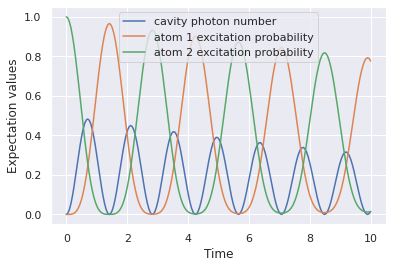

In [10]:
# times = np.linspace(0.0, 10.0, 200)
# psi0 = tensor(fock(2,0), fock(10, 5))
# a  = tensor(qeye(2), destroy(10))
# sm = tensor(destroy(2), qeye(10))
# H = 2 * np.pi * a.dag() * a + 2 * np.pi * sm.dag() * sm + 2 * np.pi * 0.25 * (sm * a.dag() + sm.dag() * a)
# result = mesolve(H, psi0, times, [np.sqrt(0.1)*a, np.sqrt(0.1)*sm], [a.dag()*a, sm.dag()*sm])

# plt.figure()
# plt.plot(times, result.expect[0])
# plt.plot(times, result.expect[1])
# plt.xlabel('Time')
# plt.ylabel('Expectation values')
# plt.legend(("cavity photon number", "atom excitation probability"))
# plt.show()

times = np.linspace(0.0, 10.0, 200)
psi0 = tensor(fock(2,0), fock(2,1), fock(10, 0))
a  = tensor(qeye(2), qeye(2), destroy(10))
sm1 = tensor(destroy(2), qeye(2)   , qeye(10))
sm2 = tensor(qeye(2)   , destroy(2), qeye(10))
H = 2*np.pi*a.dag()*a + 2*np.pi*sm1.dag()*sm1 + 2*np.pi*sm2.dag()*sm2 + 2*np.pi*0.25*(sm1*a.dag() + sm1.dag()*a) + 2*np.pi*0.25*(sm2*a.dag() + sm2.dag()*a)
result = mesolve(H, psi0, times, [np.sqrt(0.1)*a], [a.dag()*a, sm1.dag()*sm1, sm2.dag()*sm2])

plt.figure()
plt.plot(times, result.expect[0])
plt.plot(times, result.expect[1])
plt.plot(times, result.expect[2])
plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.legend(("cavity photon number", "atom 1 excitation probability", "atom 2 excitation probability"))
plt.show()